### Image preprocessing for DJI Mavic 2 Pro and Phantom 4 Multispectral (P4M) data
##### _Last update: 27 July 2022_
##### _Authors: Andrii Zaiats, Valorie Marie_
##### Purpose: This file includes image preprocessing steps that can be useful for SfM and multispectral workflows. The following steps are included:

RGB images:  

1. Converting proprietary image formats (e.g., Sony .ARW) to .dng format.
2. Converting .dng files to .jpg
3. Applying CLAHE (ontrast-limited adaptive historgram equalization) image corrections
4. Copying metadata from .dng to the newly created .jpg files  

Multispectral images:  

5. MicaSense Image Processing with calibration panel.

Required software:
* <a href="https://helpx.adobe.com/camera-raw/using/adobe-dng-converter.html">Adobe DNG Converter<a>
* <a href="https://imagemagick.org/">ImageMagick<a>
* <a href="https://exiftool.org/">ExifTool<a>
* <a href="https://github.com/micasense/imageprocessing">MicaSense GitHub Image processing repository (_see MicaSense Image Processing Setup.ipynb_)<a>

####  1. Converting proprietary image formats (e.g., Sony .ARW) to .dng format.
This steps relies on Adobe DNG Converter software (available freely).  

Instructions:  
* Select intput/output locations: input directory should contain .ARW files, output directory is where the new .dng files will apprear
* the rest of the default settings should be fine
* click Exit and verify that the new .dng files are where they should be

#### 2. Converting .dng files to .jpg  

First, specify the path where the .dng files are located (_e.g., `path = 'D:/folder1/folder2/'`_)

In [1]:
path = 'D:/Andrii/20220603_InitialPoint/mavic_rgb_images_tif/'

Next, run ImageMagick command using python interface. (There exists a designated python package for ImageMagick but currently it is not implmenented).  
_Input:_ a path to the folder with .dng images (specified above).  
_Output:_ a copy of .dng images in .jpg format in the same directory where the .dng files are. That is okay, after modifying the images we can transfer the files over to a designated, final location.

In [2]:
cmd = 'magick mogrify -format jpg -quality 100 ' + path + '*.DNG'
os.system(cmd)

0

#### 3. Applying CLAHE (contrast-limited adaptive historgram equalization) image corrections
Thic correction appears to improve the contrast while mitigating shadows in the images. Not sure what effect this may have for the ODM reconstruction process, but since .jpg file format is mostly used for SfM, changing color properties of the images may help.  

_Note: Originally, this correction required adjusting the colours in Lightroom before running the CLAHE correction (not implemented here, but maybe could be done with ImageMagick). If implemented, the colour corrections should be Shadows & Blacks +100 and Highlights & Whites -100_

In [3]:
import cv2 as cv
from os import listdir
from os.path import join

files = [s for s in listdir(path) if s.endswith('.jpg')]

# provide path to the images
for n in range(0, len(files)):
    
    fimg = join(path, files[n])
    img = cv.imread(fimg)

    img_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
    clahe = cv.createCLAHE(clipLimit = 2, tileGridSize = (8,8))

    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)

    output_image = join(path, files[n])
    cv.imwrite(output_image, img_output)


#### 4. Copying metadata from .dng to .jpg files
After steps 2 and 3, we should have a collection of .jpg files (CLAHE corrected or not) in the same folder where the original .dng files are. In this step, we use `exiftool` package to copy the metadata from the original .dng files to the newly created (and corrected) images. After copying over the metadata, this cell also moves the .jpg files to another, user specified, directory.

In [ ]:
import shutil 

cmd1 = 'exiftool -tagsfromfile %d%f.dng -all:all -overwrite_original -ext jpg ' + path 
os.system(cmd1)

for f in files:
    shutil.move(join(path, f), join(path + '/jpg'))

##### 5. Multispectral radiometric calibration
The following code is relevant to the processing P4M multispectral images only. Specifically, it implements radiometric calibration  using the DLS (on-board Downdwelling Light Sensor on Phantom 4 Multispectral). The code implements a package written specifically for this task (https://github.com/gdslab/p4m), which, in turn, heavily borrows from the MicaSense tutorials and source code.  

_Note: the default exiftool package does not work. The solution is to use a previous version of the package (`pip install pyexiftool==0.4.13` from https://github.com/micasense/imageprocessing/issues/177 )._  

_Note: to use MicaSense source code from the GitHub repo the repository needs to be activated from the specific Anaconda environment each time the code is used. If using VSCode Editor, in the top-right corner click on the current kernel and make sure to select 'micasense(Python 3.7.23)'._  


In [10]:
os.chdir('C:/Users/caugh/p4m')
os.system('conda activate P4M')
os.system('python raw2ref.py D:/Valorie/2022_field_campaign/NorthHam/multispec_images/ D:/Valorie/2022_field_campaign/NorthHam/multispec_images_refl/')

0

To-do list and questions:
* test the implementation of the above steps on Han to test package versioning/setups/environemnts
* verify DLS sensor corrects the orthomosaic artifacts - **yes.good**
* do we need to use the reflectance panel at all? is DLS sensor good enough? - **Yes - refl panel is necessary if we want to compare stuff between sites; for within-site consistency on-board calibratoin should be enough, but that's not what we're after.**
* use lossless image format (e.g., tif)?


### Test: Implementation of the p4m source code

In [ ]:
os.chdir('C:/Users/caugh/imageprocessing/')
os.system('conda activate micasense')

In [ ]:
os.chdir('C:/Users/caugh/p4m/')
os.system('conda activate P4M')

In [ ]:

import os, glob
import numpy as np
import tifffile
import micasense.capture as capture
import micasense.dls as dls
import micasense.metadata as metadata
import time
import sys
import exiftool
import json

In [ ]:
os.getcwd()

In [87]:

input_dir = "D:/Andrii/test/ci_raw/"
output_dir = "D:/Andrii/test/ci_refl/"

initial_path = os.getcwd()

# Raw Image (.TIF) should be in path "raw_images"
raw_image_list = glob.glob(os.path.join(input_dir,'*.TIF'))
#image_names = sorted(glob.glob(os.path.join(os.getcwd()+'/raw_images/100MEDIA_DJI_0192.TIF')))
print(raw_image_list)
i = 5

raw_image = raw_image_list[i]
#print("Processing %s [%d/%d] %.2f percent done." % (os.path.basename(raw_image), i+1, len(raw_image_list), float(i+1)/float(len(raw_image_list)) * 100))

print(raw_image)
cap = capture.Capture.from_filelist([raw_image])

dls_orientation_vector = np.array([0,0,-1])
    # compute sun orientation and sun-sensor angles
(
sun_vector_ned,    # Solar vector in North-East-Down coordinates
sensor_vector_ned, # DLS vector in North-East-Down coordinates
sun_sensor_angle,  # Angle between DLS vector and sun vector
solar_elevation,   # Elevation of the sun above the horizon
solar_azimuth,     # Azimuth (heading) of the sun
) = dls.compute_sun_angle(cap.location(),
                    cap.dls_pose(),
                    cap.utc_time(),
                    dls_orientation_vector)

# Get Spectral Irradiance (= Sun Sensor Irradiance) for each image from its metadata
spectral_irradiances=[]

meta = metadata.Metadata(raw_image, exiftoolPath=None)
spectral_irradiances.append(meta.get_item('XMP:Irradiance'))

dls_irradiances = []

fresnel_correction = dls.fresnel(sun_sensor_angle)
dir_dif_ratio = 6.0  # Default value from MicaSense
percent_diffuse = 1.0/dir_dif_ratio
sensor_irradiance = spectral_irradiances/fresnel_correction
untilted_direct_irr = sensor_irradiance / (percent_diffuse + np.cos(sun_sensor_angle))

# compute irradiance on the ground (= DLS Irradiance) using the solar altitude angle
dls_irr = untilted_direct_irr * (percent_diffuse + np.sin(solar_elevation))
dls_irradiances.append(dls_irr)

# Produce Reflectance Images
reflectance_image = cap.compute_reflectance(dls_irradiances)
reflectance_image = np.array(reflectance_image)[0,:,:]

# Reflectance Images (Float64 --> Int16)
reflectance_image = np.round(reflectance_image,5)
reflectance_image = np.round(reflectance_image*2**16)
# reflectance_image = np.uint16(reflectance_image)

print(np.mean(reflectance_image))
print(reflectance_image.max())
print(spectral_irradiances[0]*0.01)

['D:/Andrii/test/ci_raw\\DJI_0011.TIF', 'D:/Andrii/test/ci_raw\\DJI_0012.TIF', 'D:/Andrii/test/ci_raw\\DJI_0013.TIF', 'D:/Andrii/test/ci_raw\\DJI_0014.TIF', 'D:/Andrii/test/ci_raw\\DJI_0015.TIF', 'D:/Andrii/test/ci_raw\\DJI_0021.TIF', 'D:/Andrii/test/ci_raw\\DJI_0022.TIF', 'D:/Andrii/test/ci_raw\\DJI_0023.TIF', 'D:/Andrii/test/ci_raw\\DJI_0024.TIF', 'D:/Andrii/test/ci_raw\\DJI_0025.TIF', 'D:/Andrii/test/ci_raw\\DJI_0031.TIF', 'D:/Andrii/test/ci_raw\\DJI_0032.TIF', 'D:/Andrii/test/ci_raw\\DJI_0033.TIF', 'D:/Andrii/test/ci_raw\\DJI_0034.TIF', 'D:/Andrii/test/ci_raw\\DJI_0035.TIF']
D:/Andrii/test/ci_raw\DJI_0021.TIF
4546.378180288461
73189.0
109.35662


(array([[1.300e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.299e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [1.298e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
         1.000e+00],
        ...,
        [1.300e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.300e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.300e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([    0. ,  8475.6, 16951.2, 25426.8, 33902.4, 42378. , 50853.6,
        59329.2, 67804.8, 76280.4, 84756. ]),
 <a list of 1600 BarContainer objects>)

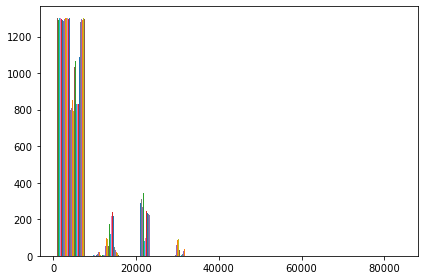

In [86]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(reflectance_image, bins=10)

In [99]:
import os, glob
from micasense.image import Image
from micasense.panel import Panel
%matplotlib inline


import os, glob
from micasense.image import Image
from micasense.panel import Panel
%matplotlib inline

imageName = raw_image

print(imageName)

img = Image(imageName)
if img.auto_calibration_image:
    print("Found automatic calibration image")
panel = Panel(img)
print(panel)
#if not panel.panel_detected():
#    raise IOError("Panel Not Detected!")
    
print("Detected panel serial: {}".format(panel.serial))
mean, std, num, sat_count = panel.raw()
print("Extracted Panel Statistics:")
print("Mean: {}".format(mean))
print("Standard Deviation: {}".format(std))
print("Panel Pixel Count: {}".format(num))
print("Saturated Pixel Count: {}".format(sat_count))

panel.plot();


D:/Andrii/test/ci_raw\DJI_0021.TIF
Detected panel serial: None


ValueError: Input must be >= 2-d.